<a href="https://colab.research.google.com/github/steflhermitte/EO-Notebooks/blob/master/PythonProgramming/RS_Notebook3_classification_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" width="200" align='right'>](https://www.tudelft.nl/citg/over-faculteit/afdelingen/geoscience-remote-sensing/staff/scientific-staff/dr-stef-lhermitte)


# Image classification using Scikit-Learn
*Created by Stef Lhermitte (s.lhermitte at tudelft.nl / [@steflhermitte](https://twitter.com/StefLhermitte) | www.earthmapps.io)*

*with inspiration and fragments from:*

[![Twitter](https://img.shields.io/twitter/url/https/twitter.com/cloudposse.svg?style=social&label=%20%40steflhermitte)](https://twitter.com/steflhermitte)



## Machine learning: short intro 
*Check also Bouwplaats lecture 2*

In this notebook we are going to do a supervised classification / machine learning exercise on one of your previously downloaded satellite images. Machine learning  is establishing the relationship between a few characteristics (features or Xs; in this case satellite reflectance) of an entity with its other property (value or label or Y; in this case landuse type). Features are essentially the same as variables in a scientific experiment, they are characteristics of the phenomenon under observation that can be quantified or measured in some fashion. When these features are fed into a machine learning framework the network tries to discern relevant patterns between the features. These patterns are then used to generate the outputs of the framework/network. The outputs of the framework are often called "labels", as the output features have some label given to them by the network, some assumption about what category the output falls into. 

In a machine learning context, classification is a type of supervised learning. Supervised learning means that the data fed to the network is already labeled, with the important features/attributes already separated into distinct categories beforehand. This means that the network knows which parts of the input are important, and there is also a target or ground truth that the network can check itself against. 

The process of training a model is the process of feeding data into a neural network and letting it learn the patterns of the data. The training process takes in the data and pulls out the features of the dataset. During the training process for a supervised classification task the network is passed both the features and the labels of the training data. However, during testing, the network is only fed features.

The testing process is where the patterns that the network has learned are tested. The features are given to the network, and the network must predict the labels. The data for the network is divided into training and testing sets, two different sets of inputs. You do not test the classifier on the same dataset you train it on, as the model has already learned the patterns of this set of data and it would be extreme bias.

Instead, the dataset is split up into training and testing sets, a set the classifier trains on and a set the classifier has never seen before. 

Scikit-Learn provides easy access to numerous different classification algorithms. Among these classifiers are:
 - [K-Nearest Neighbors](https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/)
 - [Support Vector Machines](https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/)
 - [Decision Tree Classifiers](https://stackabuse.com/decision-trees-in-python-with-scikit-learn/)/[Random Forests](https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/)
 - [Naive Bayes](https://stackabuse.com/the-naive-bayes-algorithm-in-python-with-scikit-learn/)
 - [Linear Discriminant Analysis](https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/)
 
Classification tasks are any tasks that have you putting examples into two or more classes. Determining if an image is a cat or dog is a classification task, as is determining what the classifying satellite pixels in different classes.

Depending on the classification task at hand, you will want to use different classifiers. For instance, a logistic regression model is best suited for binary classification tasks, even though multiple variable logistic regression models exist. As you gain more experience with classifiers you will develop a better sense for when to use which classifier. However, a common practice is to instantiate multiple classifiers and compare their performance against one another, then select the classifier which performs the best.

In this notebook you are going to do an image classification of your neightborhood using the spectral characteristics of the satellite and some labels that you need to digitise yourself. In this example, we are going to read the labels from Open Streetmap, but in your assignment you will digitise the labels manually.


## Before you start
Before starting this notebook make sure that you installed the necessary packages (see [Python installation example notebook](https://colab.research.google.com/drive/1MccJkybH3jEDeQ8GkU7NmtbXP8ZE4V5M?usp=sharing)). For your local computer, you only need to install the packages once and you won't need the next cell. For Colab, you need to run the following installation steps every time you start a new notebook and restart the environment afterwards. 



In [ ]:
!apt install libspatialindex-dev
!pip install osmnx
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install git+https://github.com/SciTools/cartopy.git --no-binary cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends 
!pip install shapely --no-binary shapely
!pip install matplotlib-scalebar
!pip install pyepsg
!pip install owslib
!pip install scikit-learn
!pip install geopandas
!pip install rasterio
!pip install geemap

For colab users: don't forget to restart your runtime after installation to avoid problems with matplotlib.

### Load the necessary packages

In [152]:
import cartopy.crs as ccrs
import osmnx as ox
from pyproj import CRS
import geopandas
import geemap
import ee
import rasterio
import rasterio.features
from rasterio.plot import reshape_as_raster, reshape_as_image
import os
import glob2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Now you need to authenticate Google Earth Engine and launch it in colab.



In [4]:
## Authenticate EE
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=VVEiD7F8Z0GD1bW3BldwLcM489kbMw2BVSHtCkJCMMM&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5D8pQX9f488wm2ZADBzU-stDv-G5aW2V8bNMa7olOSpPFylS7rh64

Successfully saved authorization token.


In [5]:
# Launch EE
ee.Initialize()

## Creating pixel labels for classification
Before starting a satellite classification exercise, we need pixel labels that identify each pixel to a class (e.g. the landcover type_. These labels could come from an external data set, or could be manually created. 

For example, we could load them from OpenStreetmap (Notebook 1):

In [6]:
bl=ox.geometries.geometries_from_bbox(north=52.01, south=51.98, east=4.39, west=4.36,tags={'building': True})

In [7]:
lu=ox.geometries.geometries_from_bbox(north=52.01, south=51.98, east=4.39, west=4.36,tags={'landuse': True})

In [8]:
na=ox.geometries.geometries_from_bbox(north=52.01, south=51.98, east=4.39, west=4.36,tags={'natural': True})

In [35]:
# Create vegetation class by selecting only grass and forest from the landuse
vg=lu[np.logical_or(lu['landuse']=='grass',lu['landuse']=='forest')]
# Create water class by selecting water from natural
water=na[na['natural']=='water']
water

natural  ...          type
element_type osmid             ...              
way          4960697    water  ...           NaN
             20209191   water  ...           NaN
             20209387   water  ...           NaN
             20209467   water  ...           NaN
             32909449   water  ...           NaN
...                       ...  ...           ...
relation     2316492    water  ...  multipolygon
             8610590    water  ...  multipolygon
             9592505    water  ...  multipolygon
             9796016    water  ...  multipolygon
             10506920   water  ...  multipolygon

[194 rows x 19 columns]

Or digitalise them manually (e.g. [geojson.oi](http://www.geojson.io), see short [introduction video](https://tudelft.zoom.us/rec/share/zpHPYR8Nz3KbRUi1Jb7H-wW6f59jbEP6RitC_HlTf5g4wkFhA__16q6WKsOkIVAh.OxaRB6K9itNs_NSp) (Passcode: `+=&1$JUX`) on how to digitise using geojson.io) and open the created polygon that contains the polygons for manually defined class. For example, in this example, we manually digitised a water class with two polygons and saved it as a water.json file.

![](water_geojson.png)

We can load this digitised geojson polygons via the `pygeoj` package:

In [11]:
filename='/content/map.geojson'
df = geopandas.read_file(filename)
df

,geometry
0,"POLYGON ((4.38273 51.99731, 4.38292 51.99702, ..."
1,"POLYGON ((4.38214 51.99702, 4.38227 51.99678, ..."
2,"POLYGON ((4.38176 51.99763, 4.38182 51.99753, ..."


These polygons are vectors and in the classsification we need raster labels (i.e. every pixel needs to have a label). Therefore, we need to rasterize the polygons. Before doing that we need to load the satellite image we want to classify in order to copy the image extent, geometry, etc. Based on Notebook 2 we can load the satellite imagery:

In [160]:
rectangle = ee.Geometry.Rectangle([4.36, 51.98, 4.39, 52.01])
# Load collection and filter by region, data and cloud cover metadata
S2 = (ee.ImageCollection('COPERNICUS/S2_SR')
         .filterBounds(rectangle)
         .filterDate('2021-01-01', '2021-12-31')
         .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',20))
# Sort by cloud cover metadata and take first (i.e. least cloudy image)
S2_im = S2.sort('CLOUDY_PIXEL_PERCENTAGE').first()
# Subset to take only reflectance bands starting with B
S2_im = S2_im.select('B.*')

In [158]:
# Export imagery
out_dir = '/content/'
filename = 'S2.tif'

In [161]:
geemap.ee_export_image_collection(S2, out_dir='/content', scale=10, region=rectangle, file_per_band=False, crs='EPSG:3857')

Total number of images: 4

Exporting 1/4: 20210125T105331_20210125T105443_T31UET.tif
Generating URL ...
Please wait ...
An error occurred while downloading.


Exporting 2/4: 20210326T105031_20210326T105256_T31UET.tif
Generating URL ...
Please wait ...


KeyboardInterrupt: ignored

In [155]:
# Create a list of the exported images
filelist = glob2.glob(out_dir+'*.tif')

['/content/S2.tif']

In [135]:
# Read image using rasterio
imr = rasterio.open(filename)
im = imr.read()
# Apply image scaling (see metadata) to set to reflectance
im = im * 0.0001
im = reshape_as_image(im)

Subsequently, the polygons can rasterized using the [rasterio rasterize function](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html#rasterio.features.rasterize). 

In [47]:
?rasterio.features.rasterize

/usr/local/lib/python3.7/dist-packages/google/colab/_inspector.py:386: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  oname + inspect.formatargspec(*argspec, formatvalue=formatvalue))


When applying this function, we assign different labels to each class using the `[(x, label) for x in features]` line. For example, we assign the `class=1` to buildings, `class=2` to vegetation and `class=3` to water and we use the image shape (`imr.shape`) and projection (`imr.transform`). Note also that we append data to the same matrix.

In [107]:
bl2 = ox.project_gdf(bl,to_crs=CRS.from_epsg(3857))
vg2 = ox.project_gdf(vg,to_crs=CRS.from_epsg(3857))
wa2 = ox.project_gdf(water,to_crs=CRS.from_epsg(3857))

In [108]:
lab = rasterio.features.rasterize(
    [(x, 3) for x in bl2['geometry']], # Assign label 1 to buildings
    out_shape=imr.shape,
    transform=imr.transform,
    fill=0,
    all_touched=True,
    dtype=rasterio.float32, )
lab = rasterio.features.rasterize(
    [(x, 1) for x in wa2['geometry']], # Assign label 3 to water
    out_shape=imr.shape,
    transform=imr.transform,
    out=lab,
    fill=0,
    all_touched=True,
    dtype=rasterio.float32, )
lab = rasterio.features.rasterize(
    [(x, 2) for x in vg2['geometry']], # Assign label 2 to vegetation
    out_shape=imr.shape,
    transform=imr.transform,
    out=lab,
    fill=0,
    all_touched=True,
    dtype=rasterio.float32, )

If we now simply plot the rasterized polygons, we see that each polygon is burned in an empty raster with the corresponding label.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


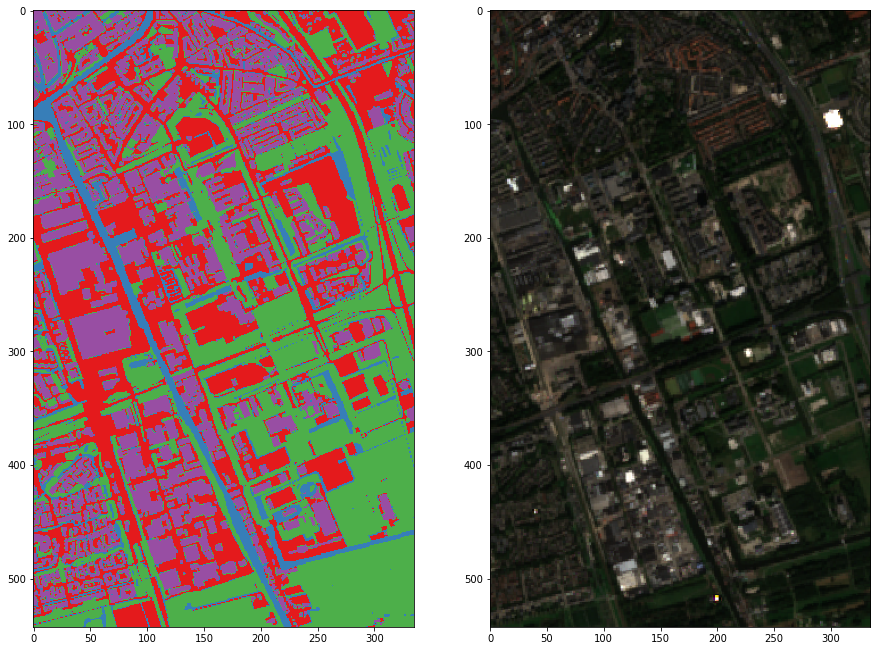

In [136]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(lab,vmin=0,vmax=8.,cmap='Set1')
ax[1].imshow(im[:,:,(3,2,1)]*2)
# ax.imshow(im[1,:,:])

## Training the classification

Once we have the labels, now let's see how to implement a classifier. 
The first step in implementing a classifier is to import the classifier you need into Python. Let's look at the import statement for K-Nearest Neighbors:

In [77]:
from sklearn.neighbors import KNeighborsClassifier

Scikit-Learn has other classifiers as well, and their respective documentation pages will show how to import them, but in general it is very similar:

In [78]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


After this, the classifier must be instantiated. Instantiation is the process of bringing the classifier into existence within your Python program - to create an instance of the classifier/object.

This is typically done just by making a variable and calling the function associated with the classifier:

In [79]:
KNN_model = KNeighborsClassifier()
SVC_model = SVC()
RFC_model = RandomForestClassifier()

We can off course further finetune the classifier by adding additional arguments to the initiation:

In [ ]:
?KNeighborsClassifier

Now the classifier needs to be trained. In order to accomplish this, the classifier must be fit with the training data. The model will learn to decide on a pixel class based on the respective reflectane values across all the bands.

Therefore we need to extract both the pixel labels and pixel reflectance data. In order to do this we need to reorganize the image data as the multispectral image should have the same number of features (bands) stacked in the same order. This implies changing the shape of the image to a two-dimensional array, which is expected by the majority of ML algorithms, where each row represents a pixel. 

![](https://miro.medium.com/max/4048/1*DP57Bv0fS9oIWP2Bdvm4-A.jpeg)

The current shape of the image is 334x205 pixels x 12 bands:

In [137]:
print(np.array(lab).shape)
print(im.shape)

(543, 335)
(543, 335, 12)


and we reshape it to:

In [138]:
mat_ft=np.reshape(im,(-1, 12)) # Reshape the image to number-of-pixels x number-of-bands
mat_lb=np.reshape(lab,(-1,1)) # Reshape the image to numbber-of-pixels x number-of-labels
print(np.shape(mat_ft))
print(np.shape(mat_lb))

(181905, 12)
(181905, 1)


Subsequently, we remove all pixels without a class by subsetting to only the pixels that have a class (i.e., in our example all pixels with 'label=o'):

In [112]:
mat_lb[:,0]

array([0., 3., 3., ..., 2., 2., 2.], dtype=float32)

In [139]:
mat_ft=mat_ft[mat_lb[:,0]!=0,:]
mat_lb=mat_lb[mat_lb[:,0]!=0,:]
print(np.shape(mat_ft))
print(np.shape(mat_lb))

(124754, 12)
(124754, 1)


We can plot the mean +- standard deviation for each class:

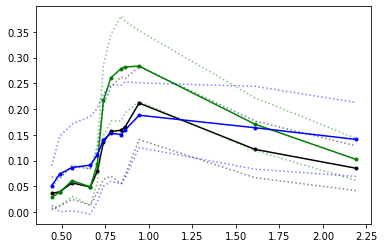

In [140]:
wl=[0.443,0.490,0.560,0.665,0.705,0.740,0.783,0.842,0.865,0.945,1.610,2.190]
colors=['black','green','blue']

for i,color in enumerate(colors):
    plt.plot(wl,np.mean(mat_ft[mat_lb[:,0]==i+1],axis=0),color=color,linestyle='-',marker='.')
    plt.plot(wl,np.mean(mat_ft[mat_lb[:,0]==i+1],axis=0)+np.std(mat_ft[mat_lb[:,0]==i+1],axis=0),color=color,linestyle=':',alpha=.5)
    plt.plot(wl,np.mean(mat_ft[mat_lb[:,0]==i+1],axis=0)-np.std(mat_ft[mat_lb[:,0]==i+1],axis=0),color=color,linestyle=':',alpha=.5)

Once the data has been preprocessed, the data must be split into training and testing sets. This is done to make sure that the model has not seen the test data and it performs equally well on new data. Otherwise, the model will overfit and perform well only on training data. Splitting can easily be done in Scikit-Learn with a helpful function called train_test_split.

In [141]:
xTrain, xTest, yTrain, yTest = train_test_split(mat_ft, mat_lb, test_size=0.3, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

(87327, 12)
(87327, 1)
(37427, 12)
(37427, 1)


The training features and the training labels are passed into the classifier with the fit command:

In [146]:
KNN_model.fit(xTrain, yTrain.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

After the classifier model has been trained on the training data, it can make predictions on the testing data.

This is easily done by calling the predict command on the classifier and providing it with the parameters it needs to make predictions about, which are the features in your testing dataset:

In [147]:
KNN_prediction = KNN_model.predict(xTest)
KNN_prediction

array([2., 3., 1., ..., 2., 2., 2.], dtype=float32)

We should now evaluate how the classifier performed. There are multiple methods of evaluating a classifier's performance (see also Bouwplaats lecture 2).

In Scikit-Learn you just pass in the predictions against the ground truth labels which were stored in your test labels:

In [148]:
# Accuracy score is the simplest way to evaluate
print('Accuracy KNN:\n',accuracy_score(KNN_prediction, yTest))
# But Confusion Matrix and Classification Report give more details about performance
print('Confusion KNN:\n',confusion_matrix(KNN_prediction, yTest))
print('Class report KNN:\n',classification_report(KNN_prediction, yTest))

Accuracy KNN:
 0.856333662863708
Confusion KNN:
 [[ 2252   605   446]
 [ 1228 16101  1270]
 [  696  1132 13697]]
Class report KNN:
               precision    recall  f1-score   support

         1.0       0.54      0.68      0.60      3303
         2.0       0.90      0.87      0.88     18599
         3.0       0.89      0.88      0.89     15525

    accuracy                           0.86     37427
   macro avg       0.78      0.81      0.79     37427
weighted avg       0.86      0.86      0.86     37427



Finally, after testing/validation, the classifier can also be applied to the complete dataset or a different image:

In [145]:
# Load images
im1 = wms_true_color_img[0]
im2 = wms_true_color_img[1]
# Reshape
mat_ft1=np.reshape(im1,(-1, 12)) # Reshape the image to number-of-pixels x number-of-bands
mat_ft2=np.reshape(im2,(-1, 12)) # Reshape the image to number-of-pixels x number-of-bands
# Predict
KNN_pred1 = KNN_model.predict(mat_ft1)
KNN_pred2 = KNN_model.predict(mat_ft2)
# Reshape predicted back to image
im1_pred = np.reshape(KNN_pred1, (imr.height, imr.width))
im2_pred = np.reshape(KNN_pred2, (imr.height, imr.width))

NameError: ignored

The resulting predictions can then be analysed. For example, by looking at the class distribution:

Text(0,0.5,'counts')

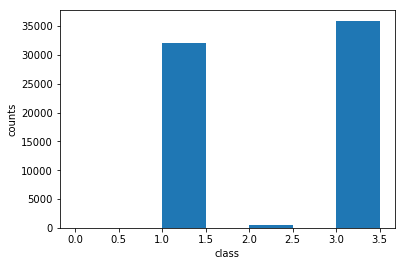

In [ ]:
plt.hist(KNN_pred1,bins=np.arange(0,4,0.5))
plt.xlabel('class')
plt.ylabel('counts')

Or by plotting it as a map:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


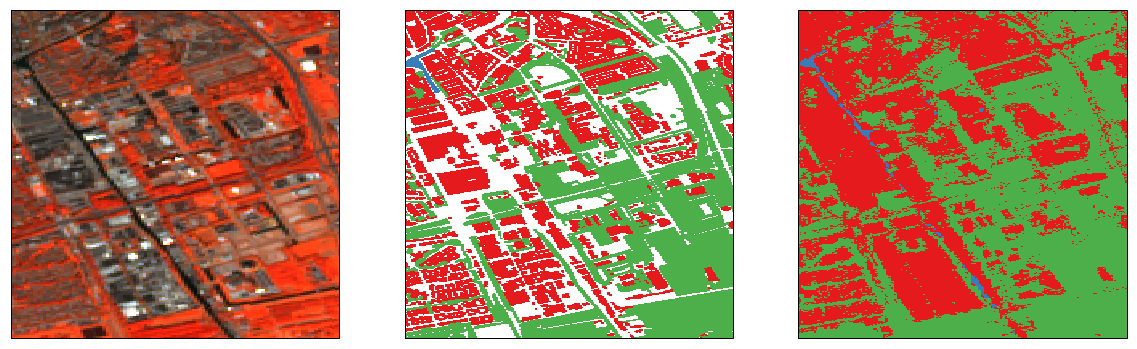

In [ ]:
crs=ccrs.PlateCarree()
ext=[4.36,4.39,51.98,52.01]
fig, axes = plt.subplots(1, 3,figsize=(20,20), subplot_kw={'projection': ccrs.PlateCarree()})
axes[0].set_extent(ext)
axes[1].set_extent(ext)
axes[2].set_extent(ext)
axes[0].imshow(im1[:,:,(8,4,3)]*2.5,extent=ext,origin='upper')
lab[lab==0]=np.nan
axes[1].imshow(lab-1,cmap='Set1',vmax=8.,vmin=0,extent=ext,origin='upper')
axes[2].imshow(im1_pred-1,cmap='Set1',vmax=8,vmin=0,extent=ext,origin='upper')

These results show that we can use classification to fill in missing pixels and provide a complete classification coverage. 

# Exercise

1.   Use your region of interest to load class labels for the 3 to 4 most prominent land use classes in your region. You can:
    * Use the polygons from OpenStreetMap of notebook 1  
    * Manually digitise the major classes.
2.   Plot the spectral profiles for each of classes for one of the bottom-of-atmosphere Sentinel-2 images over your region of interest (from Notebook 2)
3.   Use the instantiation, fitting/training, and predicting workflows for two different classifiers (e.g., KNeighborsClassifier, SVC, Random Forest, ...) for both training and testing data sets on this bottom-of-atmosphere Sentinel-2 image for all avaible bands.
    * Make a histogram of the resulting classes for each classifier
    * Produce the accuracy metrics for each classifier
    * Produce a sey of maps for each classifier that compares the initial labeled image with the classified image
4.   Use markdown cells to answer the following questions:
    * Which is the most accurate classifier and why?
    * Which classes are classified most accuratel and why? Use the spectal profiles to motivate your answer
5.   Repeat the most accurate classification but by using only the Red, Green, and Blue bands:
    * What is the effect on the accuracy and why?
  